# Run network model

In [39]:
%load_ext autoreload
%autoreload 2

#from keras.layers import merge
from src.models.data import *
from src.models.model import *
from src.data.utils import get_tile_prefix
from src.models.metrics_img import auc_roc
#import rasterio.plot as rioplot
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, LambdaCallback

from pathlib import Path
import os, shutil
import sys
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## User settings

In [41]:
# paths to append
sys.path.append("/home/ubuntu/roaddetection/")
sys.path.append("/media/hh/hd_internal/hh/DSR_Berlin_2018/roaddetection/")

# ------------- image characteristics and augmentation -----------------------------
# size of tiles
target_size = (512,512)
# input arguments to Keras' ImageDataGenerator
data_gen_args = dict(
                    data_format="channels_last",
                    horizontal_flip=True, 
                    vertical_flip=True
 )
# if True, image tiles will be split up into training/validation/test sets
# only required after a fresh 'make data'
do_data_split = True
# directory into which to place *training* images from ImageDataGenerator for inspection;
# default should be None because this slows things down
imgdatagen_dir = None
#imgdatagen_dir = '../../data/imgdatagenerator'

#--------------- network weights ----------------------------------------------------
# path to & filename of pre-trained model to use - set to None if you want to start from scratch
# pretrained_model_fn = "../../models/unet_membrane_analytic_27_08_14_55.hdf5"
pretrained_model_fn = '../../models/unet_borneo_and_harz_03_09_16_15.hdf5'

# path to & filename of model to save
trained_model_fn = '../../models/unet_borneo_and_harz_03_09_16_15.hdf5'

#--------------- training details / hyperparameters -----------------------------------
# batch size
batch_size = 5
# steps per epoch, should correspond to [number of training images] / batch size
steps_per_epoch = 200
# number of epochs
epochs = 15
# number of steps on validation set
validation_steps = 50
# self-explanatory variables:
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
loss_weights = None
metrics = ['accuracy', auc_roc]

### Define and make (if necessary) train/validation/test directories

In [42]:
original_dataset_dir = "../../data/train"
raw_images_path = "../../data/raw/images"
dirs = []

base_dir = "../../data"

train_dir = os.path.join(base_dir, "train")
dirs.append(train_dir)
validation_dir = os.path.join(base_dir, "validate")
dirs.append(validation_dir)
test_dir = os.path.join(base_dir, "test")
dirs.append(test_dir)

In [43]:
for directory in dirs:
    if not os.path.exists(directory):
        os.mkdir(directory)

In [44]:
# Delete map, sat, sat_rgb tiles with (almost) zero road labels 

import skimage.io as io

def should_delete(fname):
    img = io.imread(fname.as_posix())
    almost_empty = not len(img[img!=0.0]) > 500
#     almost_empty = not np.any(img)
    return almost_empty
    
tiles_with_no_roads = [ fname.name for fname in 
                          Path( os.path.join(train_dir, 'map')).iterdir() 
                       if should_delete(fname) ]

print(len(tiles_with_no_roads))
print("Deleting {} tiles with no roads".format(len(tiles_with_no_roads)))
for fname in tiles_with_no_roads:
    for file_type in ["sat", "map", "sat_rgb"]:
        src = os.path.join(train_dir, file_type, fname)
        if(os.path.exists(src)):
            os.remove(src)

0
Deleting 0 tiles with no roads


### Split data up into train/validation/test images

In [45]:
if do_data_split:
    def should_make_tiles_from(r_analytic_name):
        is_analytic_tif = r_analytic_name.endswith(
            ('AnalyticMS.tif', 'AnalyticMS_SR.tif', 'AnalyticMS.tiff', 'AnalyticMS_SR.tiff')
        )
        return is_analytic_tif 

    file_prefixes = [ get_tile_prefix(r_analytic.name) 
                      for r_analytic in Path(raw_images_path).iterdir()  
                        if  should_make_tiles_from(r_analytic.name)
                    ]
#     print(file_prefixes)

    # move files to validation dir
    validation_fnames = ["{0:s}_{1:04d}.tif".format(prefix, i) for i in range(10,45) for prefix in file_prefixes]
    for fname in validation_fnames:
        for file_type in ["sat", "map", "sat_rgb"]:
            src = os.path.join(train_dir, file_type, fname)
            dest = os.path.join(validation_dir, file_type, fname)
            if(os.path.exists(src)):
                shutil.move(src, dest)
    # move files to test dir
    test_fnames = ["{0:s}_{1:04d}.tif".format(prefix, i) for i in range(40,60) for prefix in file_prefixes]
    for fname in test_fnames:
        for file_type in ["sat", "map", "sat_rgb"]:
            src = os.path.join(train_dir, file_type, fname)
            dest = os.path.join(test_dir, file_type, fname)
            if(os.path.exists(src)):
                shutil.move(src, dest)
    # print overview
    for directory in dirs:
        for file_type in ["sat", "map", "sat_rgb"]:
            target = os.path.join(directory, file_type)
            print(target, ":", len(os.listdir(target)))

    print("Done.")

../../data/train/sat : 1031
../../data/train/map : 1031
../../data/train/sat_rgb : 1031
../../data/validate/sat : 378
../../data/validate/map : 378
../../data/validate/sat_rgb : 378
../../data/test/sat : 192
../../data/test/map : 192
../../data/test/sat_rgb : 192
Done.


### Set up ImageDataGenerators for training and validation sets

In [46]:
train_gen = trainGenerator(batch_size,'../../data/train','sat','map',
                        data_gen_args, save_to_dir = imgdatagen_dir, image_color_mode="rgba", target_size=target_size)

validation_gen = trainGenerator(batch_size,'../../data/validate','sat','map',
                        data_gen_args, save_to_dir = None, image_color_mode="rgba", target_size=target_size)

### Define model, compile, show summary, possibly load weights, define callbacks (including checkpoints)

In [47]:
model = unet()
model.compile(optimizer=optimizer,
              loss=loss,
              loss_weights=loss_weights,
              metrics=metrics)
model.summary()
if (pretrained_model_fn):
    model.load_weights(pretrained_model_fn)
model_checkpoint = ModelCheckpoint(trained_model_fn, monitor='loss',verbose=1, save_best_only=True)

#Stop training if loss doesn't improve for 2 consecutive epochs
early_stop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=1, mode='auto', baseline=None)

/home/ubuntu/roaddetection/src/models/model.py:58: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`
  model = Model(input=inputs, output=conv10)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 512, 512, 4)  0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 512, 512, 64) 2368        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 512, 512, 64) 36928       conv2d_49[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 256, 256, 64) 0           conv2d_50[0][0]                  
__________________________________________________________________________________________________
conv2d_51 

### Run training

In [49]:
import json
import logging

def get_logger():
    log_fmt = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    logging.basicConfig(level=logging.INFO, format=log_fmt)
    formatter = logging.Formatter(log_fmt)
    fh = logging.FileHandler('../../logs/unet.log')
    fh.setFormatter(formatter)
    logger = logging.getLogger(__name__)
    logger.addHandler(fh)
    return logger

In [52]:
logger = get_logger()
logging_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: logger.info({'epoch': epoch, 'logs': logs})
)

In [53]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              callbacks=[model_checkpoint, early_stop, logging_callback],
                              validation_data=validation_gen,
                              validation_steps=validation_steps
                             )

Epoch 1/15
200/200 [==============================] - 196s 978ms/step - loss: 0.0833 - acc: 0.9744 - auc_roc: 0.8937 - val_loss: 0.1168 - val_acc: 0.9660 - val_auc_roc: 0.8937


2018-09-03 15:14:40,654 - __main__ - INFO - {'epoch': 0, 'logs': {'val_loss': 0.11683076316671025, 'acc': 0.9744006541371345, 'loss': 0.08328881192021072, 'val_acc': 0.9659800390082021, 'val_auc_roc': 0.8936852579635959, 'auc_roc': 0.8937369975447654}}



Epoch 00001: loss did not improve from 0.08290
Epoch 2/15
200/200 [==============================] - 195s 974ms/step - loss: 0.0791 - acc: 0.9751 - auc_roc: 0.8976 - val_loss: 0.1067 - val_acc: 0.9645 - val_auc_roc: 0.9014

Epoch 00002: loss improved from 0.08290 to 0.07896, saving model to ../../models/unet_borneo_and_harz_03_09_16_15.hdf5


2018-09-03 15:17:58,397 - __main__ - INFO - {'epoch': 1, 'logs': {'val_loss': 0.10672462277955586, 'acc': 0.9750956264605005, 'loss': 0.07896316177903648, 'val_acc': 0.9645219918700957, 'val_auc_roc': 0.9014083416231217, 'auc_roc': 0.8976287837009354}}


Epoch 3/15
200/200 [==============================] - 195s 974ms/step - loss: 0.0773 - acc: 0.9754 - auc_roc: 0.9040 - val_loss: 0.1005 - val_acc: 0.9673 - val_auc_roc: 0.9062

Epoch 00003: loss improved from 0.07896 to 0.07731, saving model to ../../models/unet_borneo_and_harz_03_09_16_15.hdf5


2018-09-03 15:21:16,047 - __main__ - INFO - {'epoch': 2, 'logs': {'val_loss': 0.10047148123383522, 'acc': 0.975463230447118, 'loss': 0.07730527052910154, 'val_acc': 0.9672595798969269, 'val_auc_roc': 0.9062214958667755, 'auc_roc': 0.9040203304534935}}


Epoch 4/15
200/200 [==============================] - 194s 972ms/step - loss: 0.0752 - acc: 0.9761 - auc_roc: 0.9080 - val_loss: 0.1065 - val_acc: 0.9643 - val_auc_roc: 0.9099

Epoch 00004: loss improved from 0.07731 to 0.07536, saving model to ../../models/unet_borneo_and_harz_03_09_16_15.hdf5


2018-09-03 15:24:33,248 - __main__ - INFO - {'epoch': 3, 'logs': {'val_loss': 0.10652911109519342, 'acc': 0.9760476240072863, 'loss': 0.07535562036843245, 'val_acc': 0.9643433803031521, 'val_auc_roc': 0.9099407395528208, 'auc_roc': 0.9079944151472376}}


Epoch 5/15
200/200 [==============================] - 194s 971ms/step - loss: 0.0767 - acc: 0.9756 - auc_roc: 0.9109 - val_loss: 0.1032 - val_acc: 0.9675 - val_auc_roc: 0.9121


2018-09-03 15:27:47,549 - __main__ - INFO - {'epoch': 4, 'logs': {'val_loss': 0.1032014670180938, 'acc': 0.9756492474471709, 'loss': 0.07656249292494063, 'val_acc': 0.9675315582463818, 'val_auc_roc': 0.9121081156115378, 'auc_roc': 0.9109239366997677}}



Epoch 00005: loss did not improve from 0.07536
Epoch 6/15
200/200 [==============================] - 195s 974ms/step - loss: 0.0735 - acc: 0.9763 - auc_roc: 0.9131 - val_loss: 0.1111 - val_acc: 0.9638 - val_auc_roc: 0.9142

Epoch 00006: loss improved from 0.07536 to 0.07335, saving model to ../../models/unet_borneo_and_harz_03_09_16_15.hdf5


2018-09-03 15:31:05,368 - __main__ - INFO - {'epoch': 5, 'logs': {'val_loss': 0.11113372348248958, 'acc': 0.9763460985747686, 'loss': 0.07334545435361474, 'val_acc': 0.9638286137580871, 'val_auc_roc': 0.9141578638553619, 'auc_roc': 0.9130748838305952}}


Epoch 7/15
200/200 [==============================] - 194s 972ms/step - loss: 0.0732 - acc: 0.9766 - auc_roc: 0.9149 - val_loss: 0.0990 - val_acc: 0.9673 - val_auc_roc: 0.9157

Epoch 00007: loss improved from 0.07335 to 0.07313, saving model to ../../models/unet_borneo_and_harz_03_09_16_15.hdf5


2018-09-03 15:34:22,741 - __main__ - INFO - {'epoch': 6, 'logs': {'val_loss': 0.09900211421171984, 'acc': 0.9766777947126143, 'loss': 0.07313339876751583, 'val_acc': 0.9672776220306274, 'val_auc_roc': 0.9156628443348792, 'auc_roc': 0.9148722533959461}}


Epoch 8/15
200/200 [==============================] - 194s 972ms/step - loss: 0.0746 - acc: 0.9759 - auc_roc: 0.9164 - val_loss: 0.0996 - val_acc: 0.9671 - val_auc_roc: 0.9172


2018-09-03 15:37:37,066 - __main__ - INFO - {'epoch': 7, 'logs': {'val_loss': 0.09962864413917545, 'acc': 0.9759584640163973, 'loss': 0.07429622357008028, 'val_acc': 0.9671220803453077, 'val_auc_roc': 0.9172088979713379, 'auc_roc': 0.916436094715892}}



Epoch 00008: loss did not improve from 0.07313
Epoch 9/15
200/200 [==============================] - 195s 973ms/step - loss: 0.0712 - acc: 0.9769 - auc_roc: 0.9181 - val_loss: 0.0927 - val_acc: 0.9694 - val_auc_roc: 0.9189

Epoch 00009: loss improved from 0.07313 to 0.07089, saving model to ../../models/unet_borneo_and_harz_03_09_16_15.hdf5


2018-09-03 15:40:54,572 - __main__ - INFO - {'epoch': 8, 'logs': {'val_loss': 0.09266022644937039, 'acc': 0.9769316341383869, 'loss': 0.07089433467471935, 'val_acc': 0.9693775308132172, 'val_auc_roc': 0.9188965857028961, 'auc_roc': 0.9181144402687809}}


Epoch 10/15
200/200 [==============================] - 194s 972ms/step - loss: 0.0683 - acc: 0.9773 - auc_roc: 0.9200 - val_loss: 0.1051 - val_acc: 0.9655 - val_auc_roc: 0.9209

Epoch 00010: loss improved from 0.07089 to 0.06820, saving model to ../../models/unet_borneo_and_harz_03_09_16_15.hdf5


2018-09-03 15:44:11,926 - __main__ - INFO - {'epoch': 9, 'logs': {'val_loss': 0.1051018024914928, 'acc': 0.9773454272962478, 'loss': 0.06819951527725801, 'val_acc': 0.9655331798618839, 'val_auc_roc': 0.9208670371482449, 'auc_roc': 0.9199533286582993}}


Epoch 11/15
200/200 [==============================] - 194s 972ms/step - loss: 0.0704 - acc: 0.9770 - auc_roc: 0.9213 - val_loss: 0.0974 - val_acc: 0.9679 - val_auc_roc: 0.9221


2018-09-03 15:47:26,392 - __main__ - INFO - {'epoch': 10, 'logs': {'val_loss': 0.09737924278353251, 'acc': 0.9769399249888807, 'loss': 0.07042755077155419, 'val_acc': 0.9679128568499319, 'val_auc_roc': 0.9221354138947302, 'auc_roc': 0.921334075341263}}



Epoch 00011: loss did not improve from 0.06820
Epoch 12/15
200/200 [==============================] - 195s 973ms/step - loss: 0.0669 - acc: 0.9779 - auc_roc: 0.9229 - val_loss: 0.0938 - val_acc: 0.9690 - val_auc_roc: 0.9236

Epoch 00012: loss improved from 0.06820 to 0.06703, saving model to ../../models/unet_borneo_and_harz_03_09_16_15.hdf5


2018-09-03 15:50:43,985 - __main__ - INFO - {'epoch': 11, 'logs': {'val_loss': 0.09384389460086823, 'acc': 0.9778898502569122, 'loss': 0.06702509545440595, 'val_acc': 0.9690225338935852, 'val_auc_roc': 0.9236368978023529, 'auc_roc': 0.9228518845206762}}


Epoch 13/15
200/200 [==============================] - 195s 973ms/step - loss: 0.0684 - acc: 0.9773 - auc_roc: 0.9243 - val_loss: 0.1053 - val_acc: 0.9676 - val_auc_roc: 0.9248


2018-09-03 15:53:58,530 - __main__ - INFO - {'epoch': 12, 'logs': {'val_loss': 0.10530261991305216, 'acc': 0.9772267349991932, 'loss': 0.06855460522269988, 'val_acc': 0.9675917161568519, 'val_auc_roc': 0.9247810999231953, 'auc_roc': 0.9242788891955073}}



Epoch 00013: loss did not improve from 0.06703
Epoch 14/15
200/200 [==============================] - 194s 972ms/step - loss: 0.0667 - acc: 0.9778 - auc_roc: 0.9252 - val_loss: 0.0999 - val_acc: 0.9669 - val_auc_roc: 0.9258

Epoch 00014: loss improved from 0.06703 to 0.06687, saving model to ../../models/unet_borneo_and_harz_03_09_16_15.hdf5


2018-09-03 15:57:15,945 - __main__ - INFO - {'epoch': 13, 'logs': {'val_loss': 0.09987927832069897, 'acc': 0.9777385178938448, 'loss': 0.06687063726607755, 'val_acc': 0.9669093806897441, 'val_auc_roc': 0.9258396065523548, 'auc_roc': 0.9252342085043589}}


Epoch 15/15
200/200 [==============================] - 195s 974ms/step - loss: 0.0642 - acc: 0.9784 - auc_roc: 0.9265 - val_loss: 0.1013 - val_acc: 0.9663 - val_auc_roc: 0.9271

Epoch 00015: loss improved from 0.06687 to 0.06420, saving model to ../../models/unet_borneo_and_harz_03_09_16_15.hdf5


2018-09-03 16:00:33,558 - __main__ - INFO - {'epoch': 14, 'logs': {'val_loss': 0.10129502840340138, 'acc': 0.9784193306443203, 'loss': 0.0641979173996512, 'val_acc': 0.9662859964370728, 'val_auc_roc': 0.92713299036026, 'auc_roc': 0.9264514208677782}}


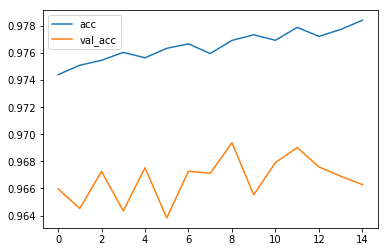

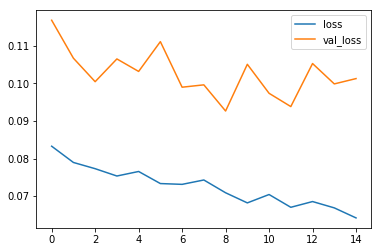

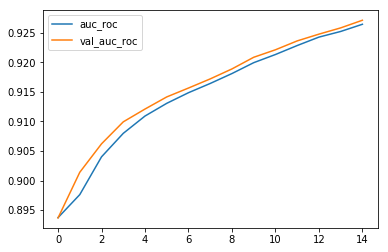

In [54]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history["acc"], label="acc")
    plt.plot(history["val_acc"], label="val_acc")
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.plot(history["auc_roc"], label="auc_roc")
    plt.plot(history["val_auc_roc"], label="val_auc_roc")
    plt.legend()
    plt.show()
    plt.close()

plot_history(history.history)

In [37]:
print(history.history)

{'val_loss': [0.15111123360693454, 0.11265804544091225, 0.09736075177788735, 0.1093273222522468, 0.10353506132960319], 'acc': [0.9729157412052154, 0.9750498813390732, 0.9741975296168558, 0.9749517524242401, 0.9746131132687291], 'loss': [0.09328662637621164, 0.07989071313291789, 0.08291095124197102, 0.08041571797803045, 0.08174248952268352], 'val_acc': [0.955501937866211, 0.9634040832519531, 0.9692430526018143, 0.9655407089359906, 0.9677986115217209], 'val_auc_roc': [0.8609775125980377, 0.885262981057167, 0.8935309767723083, 0.8975710236296361, 0.9001596540212631], 'auc_roc': [0.7992056733369828, 0.8733948016166687, 0.8896155453497364, 0.8960032451152802, 0.8996111599187697]}


In [55]:
testGene = testGenerator("../../data/test/sat",target_size=(512,512),as_gray=False)
n = 0
for img, name in testGene:
    results = model.predict(img, batch_size=1)
    saveResult("../../data/test/predict", results, name)
    n += 1
    if(n>300):
        break

/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/20171013_232848_0c46_3B_0055.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/20170815_005028_0c0b_3B_0049.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/20180427_020347_103a_3B_0051.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/20180427_020501_103c_3B_0051.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/20180427_020503_103c_3B_0058.tif is a low contrast i